Devised by florianst for Oxford Strategy Group Digital, 2020. Optimised to run locally under 16GB RAM and 2GB VRAM.

This analysis focuses on product level, i.e.:
- Given the products, is there a certain category / function we can expand on / discount across all stores? What sizes should we be focussing on? What colours?
- How do we price them? 

All data in this file has been anonymised.

In [1]:
import sys
sys.path += ['C:\\Program Files\\Python37\\lib\\site-packages']

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

C:\Users\Florian\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
pd.set_option('display.max_columns', None) # display all columns in a dataframe

sales17 = pd.read_csv("data/20200120_sales17.csv")
#sales17.head()

In [3]:
barcode = pd.read_csv("data/20200120_barcode.csv")
#barcode.head()

C:\Users\Florian\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Combine sales data with product data for a subset of the points

In [4]:
numSamples = int(4e5) # sample for memory reasons

sales = sales17.drop(['Scontrino'], axis=1)
sales = sales.join(barcode.drop([...], axis=1).set_index('EAN'), on='EAN', how='left')

sales = sales[sales['Volume'] > 0] # do not consider returns
sales = sales[sales['Incasso'] > 0]
sales = sales[sales['Stagione'] == 'PE'] # remove fall/winter collection data points (this could become a categorical column)
print("before sampling", sales.shape)

sales = sales.sample(numSamples) # sample a subset of points for memory reasons
temp = sales[['Negozio', 'EAN']].copy() # save for later use
columnsTemp = ['Negozio', 'EAN']

sales = sales.drop(['EAN', 'Stagione', 'Negozio'], axis=1) # don't need this any more after joining
del sales17, barcode # save RAM

sales['Profit'] = sales['Incasso']/sales['Volume']-sales['Costo STD']

sales = sales.drop(['Volume', 'Data', 'Ora', 'Product ID', 'Costo STD'], axis=1) # TODO: feature engineering required here (date), could maybe learn from Incasso too

print("after sampling", sales.shape)
#sales.head()

before sampling (33709842, 19)
after sampling (400000, 12)


Turn into one-hot encoding for categorical columns

In [5]:
categoricalColumns = ['Indice Taglia', 'Codice Colore', 'Codice Settore', 'Codice Articolo', 'Categoria Merc.', 'Periodo Immissione', 'Rotazione', 'Contenuto Moda', 'Stagionalita', 'Contenuto Novita']
categoryLengths = [len(sales[colName].unique()) for colName in categoricalColumns]

sales = pd.get_dummies(sales, prefix=categoricalColumns, columns=categoricalColumns)

# create numpy arrays for prediction
y = sales['Profit'].to_numpy() # predict sale volume
sales = sales.drop(['Profit'], axis=1)
X = sales.to_numpy()

# find beginning index for each categorical column in the new one-hot array
colStarts = np.zeros(len(categoricalColumns))
for i, findColName in enumerate(categoricalColumns):
    for colNumber, colName in enumerate(sales.columns):
        if (colName[:len(findColName)] == findColName):
            colStarts[i] = colNumber
            break

print(sales.shape)
#sales.head()

(400000, 286)


Generate random data of the same shape as sales to provide model with negative labels (no purchase)

In [6]:
# initialise random data of same shape as sales dataframe
n_samples, n_labels = X.shape
X_rand = np.zeros((n_samples, n_labels))

# integer columns: Data, Ora, Volume, Incasso, Product ID
#hour = np.random.randint(9, 22, n_samples) # excludes high point
#minute = np.random.randint(0, 60, n_samples)
#minute = ['0'+str(m) if m<10 else str(m) for m in minute]
#X_rand[:,sales.columns.get_loc('Ora')] = [int(str(x)+str(y)) for x,y in zip(hour, minute)]
# TODO: adjust these distributions to match the real ones more closely (i.e. not Gaussian)

for colName in ['Incasso']:
    if (colName in ['Incasso', 'Profit']): nDecimals = 2
    else:                                  nDecimals = 0
    X_rand[:,sales.columns.get_loc(colName)] = np.round(np.random.normal(sales[colName].mean(), sales[colName].std(), n_samples), nDecimals)

# categorical columns
for _colName, colStart, categoryLength in zip(categoricalColumns, colStarts, categoryLengths):
    probs = [np.sum(X[:,int(colStart+col)]) for col in range(categoryLength)]
    probs /= np.sum(probs) # normalise probabilities
    J = np.random.choice(categoryLength, n_samples, p=probs)+int(colStart)
    X_rand[np.arange(n_samples), J] = 1 # distribute a random one within the current category for each data point

X = np.concatenate((X, X_rand))
y = np.concatenate((y, [0]*(len(X)-len(y)))) # Profit=0 means not a sale
temp = pd.concat((temp, pd.DataFrame(0, index=np.arange(len(temp.index)), columns=temp.columns)))
print(X.shape, y.shape, temp.shape)

# some sanity checks
unique, counts = np.unique(X[:,5], return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(X[:,-1], return_counts=True)
print(dict(zip(unique, counts)))

#unique, counts = np.unique(y, return_counts=True)
#print(dict(zip(unique, counts)))

(800000, 286) (800000,) (800000, 2)
{0.0: 637601, 1.0: 162399}
{0.0: 791934, 1.0: 8066}


Train an XGboost tree regressor for the sales volume, explain using TreeSHAP

In [7]:
columnNames = sales.columns
del sales # save some RAM

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, temp_train, temp_test = train_test_split(X, y, temp, test_size=0.2)
del X, y, temp # save some RAM

import xgboost
import shap
trainmatrix, testmatrix = xgboost.DMatrix(X_train, label=y_train), xgboost.DMatrix(X_test, label=y_test)
#del X_train, y_train, temp_train # need X_test, y_test, temp_test for SHAP

[0]	train-rmse-mean-rmse:2.15820	eval-rmse-mean-rmse:2.14508
[10]	train-rmse-mean-rmse:1.20016	eval-rmse-mean-rmse:1.19721
[20]	train-rmse-mean-rmse:1.06353	eval-rmse-mean-rmse:1.08717
[30]	train-rmse-mean-rmse:0.98022	eval-rmse-mean-rmse:1.00819
[40]	train-rmse-mean-rmse:0.93273	eval-rmse-mean-rmse:0.97669
[50]	train-rmse-mean-rmse:0.90535	eval-rmse-mean-rmse:0.95791
[60]	train-rmse-mean-rmse:0.87451	eval-rmse-mean-rmse:0.93209
[70]	train-rmse-mean-rmse:0.85592	eval-rmse-mean-rmse:0.92228
[80]	train-rmse-mean-rmse:0.83051	eval-rmse-mean-rmse:0.90615
[90]	train-rmse-mean-rmse:0.81196	eval-rmse-mean-rmse:0.89577
[100]	train-rmse-mean-rmse:0.79645	eval-rmse-mean-rmse:0.88766
[110]	train-rmse-mean-rmse:0.78195	eval-rmse-mean-rmse:0.87982
[120]	train-rmse-mean-rmse:0.77193	eval-rmse-mean-rmse:0.87450
[130]	train-rmse-mean-rmse:0.76082	eval-rmse-mean-rmse:0.87344
[140]	train-rmse-mean-rmse:0.75432	eval-rmse-mean-rmse:0.87108
[150]	train-rmse-mean-rmse:0.74566	eval-rmse-mean-rmse:0.86601
[16

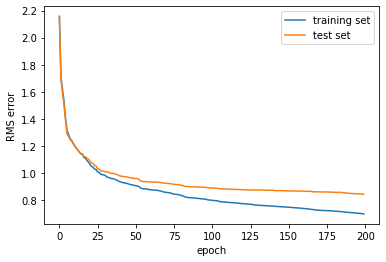

In [9]:
# initialise values
model, explainer, shap_values, progress = None, None, None, dict()

# train XGBoost model
params = {'tree_method': 'gpu_hist', 'learning_rate': 1.2} # if not training on GPU, remove 'tree_method' entry
epochs = 200
#params['eval_metric'] = 'error'
#params['silent'] = 1
watchlist  = [(trainmatrix,'train-rmse-mean'), (testmatrix, 'eval-rmse-mean')]
model = xgboost.train(params, trainmatrix, epochs, watchlist, evals_result=progress, verbose_eval=10)

# plot training performance
plt.plot(range(len(progress['train']['rmse-mean-rmse'])), progress['train']['rmse-mean-rmse'], label='training set')
plt.plot(range(len(progress['eval']['rmse-mean-rmse'])), progress['eval']['rmse-mean-rmse'], label='test set')
plt.legend()
plt.xlabel("epoch")
plt.ylabel("RMS error")
fig = plt.gcf()
plt.show()
fig.savefig("xgboost_training.pdf", dpi=300, bbox_inches='tight')
plt.close()

Explain the model's predictions using SHAP values

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


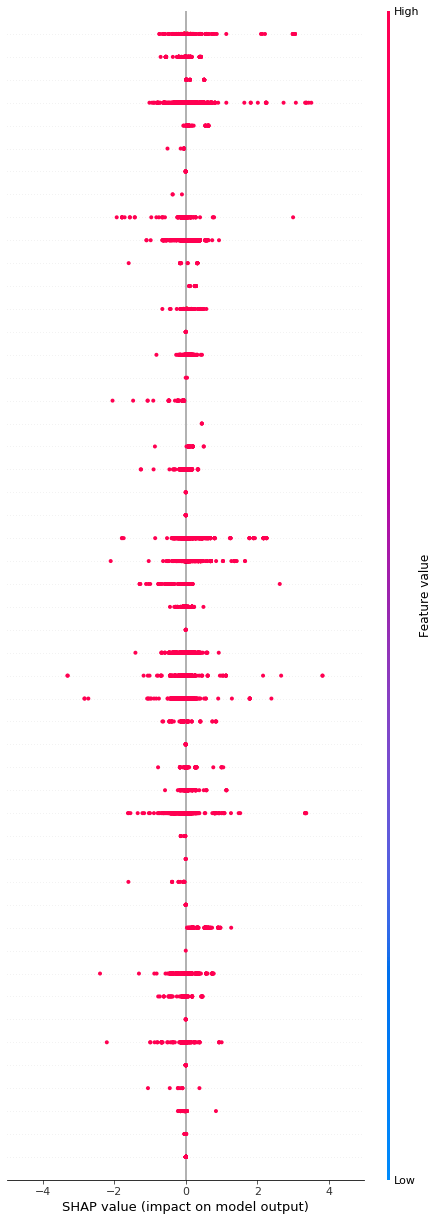

Mean of empty slice


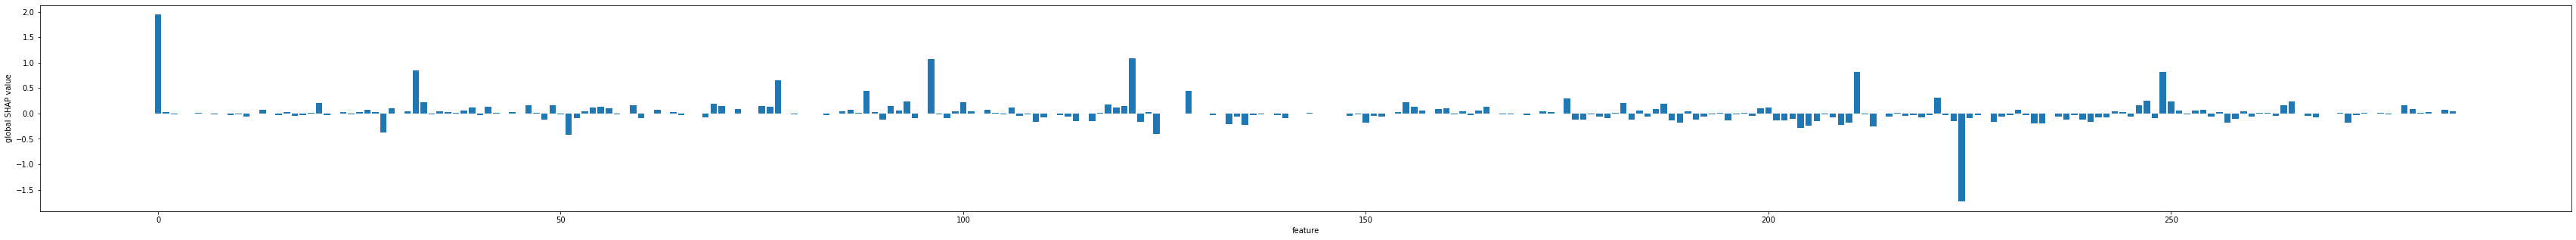

In [10]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap_values_train = explainer.shap_values(X_train)

# for boolean features, only plot High (set Low to nan)
high_mask = (X_test == 0)
masked_shap_values = np.copy(shap_values) # need a deep copy here apparently
masked_shap_values[high_mask] = np.nan

# summarize the effects of all the features
shap.summary_plot(masked_shap_values, X_test, feature_names=[""]*len(X_test), max_display=50, show=False) # anonymise data
plt.xlim(-5,5)
fig = plt.gcf()
plt.show()
fig.savefig('shapsummary.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.close()

# visualise averages across points in barplot
global_shap_values = np.nanmean(masked_shap_values, axis=0) # average SHAP values across points
xvals = range(global_shap_values.shape[0])
plt.figure(figsize=(60,5))
plt.bar(xvals, global_shap_values)
#plt.xticks(xvals, columnNames, rotation='vertical')
plt.xlabel("feature")
plt.ylabel("global SHAP value")
plt.show()
plt.close()

In [11]:
import pickle
pickle.dump((model, X_test, y_test, temp_test, shap_values, columnNames, columnsTemp), open("model_dump.pickle", "wb"))

In [12]:
import pickle
model, X_test, y_test, temp_test, shap_values, columnNames, columnsTemp = pickle.load(open("model_dump.pickle", "rb"))

Plot SHAP dependence plots of Incasso - high SHAP value suggests low price elasticity of demand

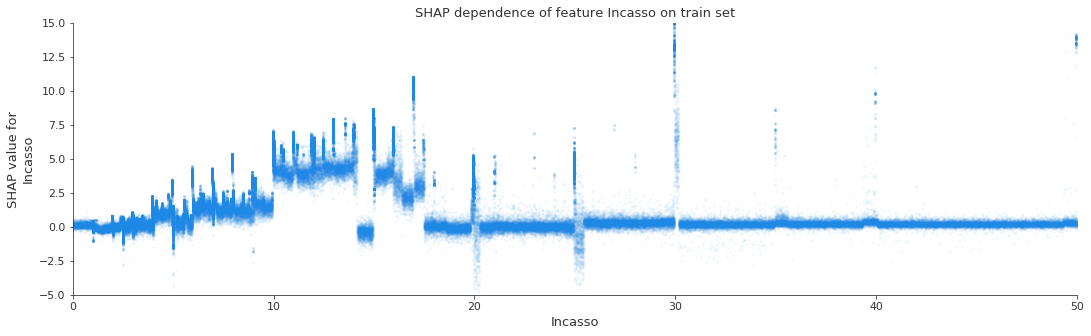

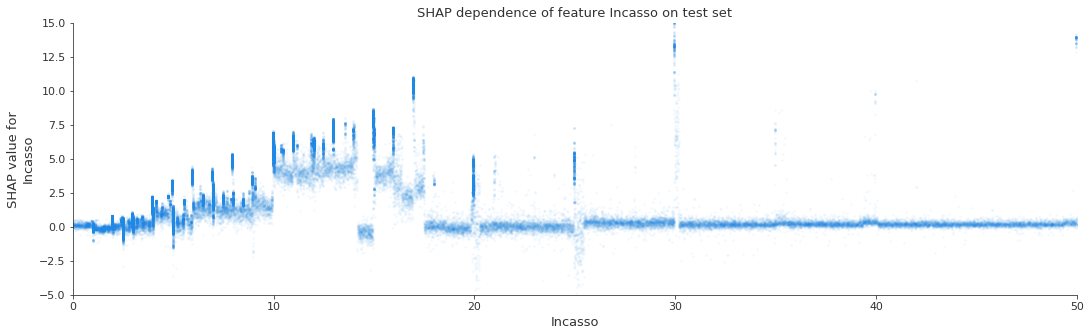

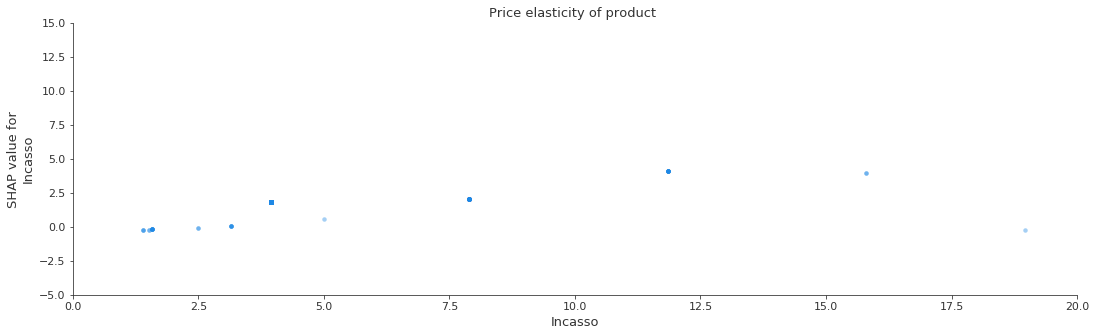

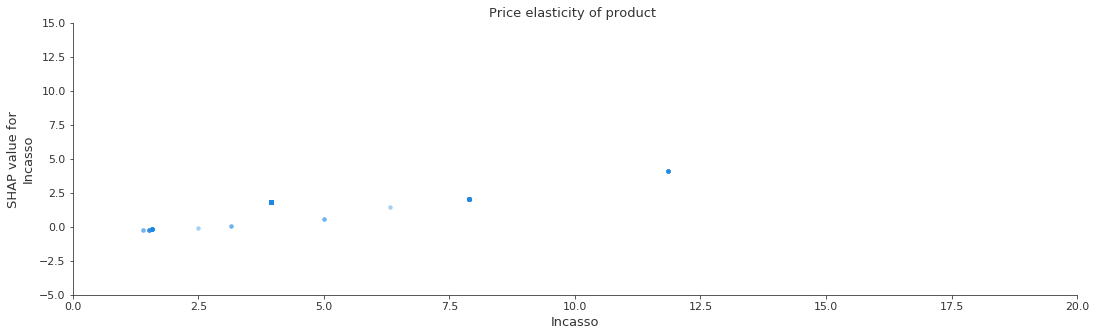

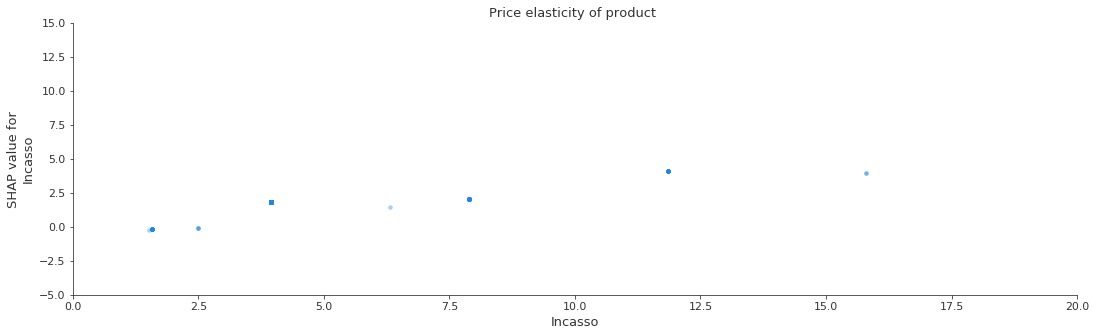

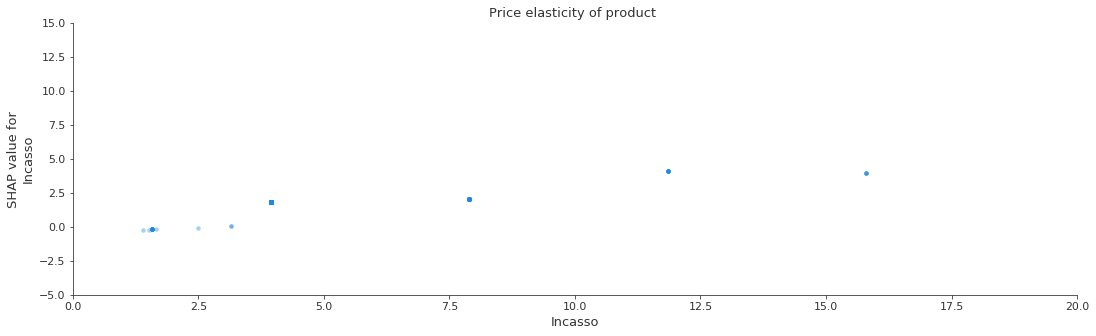

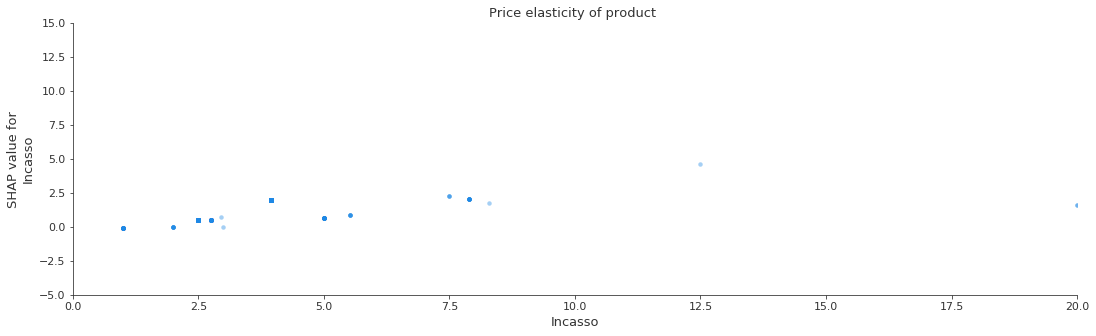

In [13]:
plot_feature = columnNames.tolist().index("Incasso")

# plot overall elasticity (train set)
shap.dependence_plot(plot_feature, shap_values_train, X_train, feature_names=columnNames, dot_size=7, alpha=0.05,
                     interaction_index=None, 
                     title="SHAP dependence of feature "+columnNames[plot_feature]+" on train set", show=False)
plt.xlim(0, 50)
plt.ylim(-5, 15)
fig = plt.gcf()
fig.set_size_inches(18,5)
plt.show()
plt.close()

# plot overall elasticity (test set)
shap.dependence_plot(plot_feature, shap_values, X_test, feature_names=columnNames, dot_size=7, alpha=0.05,
                     interaction_index=None, 
                     title="SHAP dependence of feature "+columnNames[plot_feature]+" on test set", show=False)
plt.xlim(0, 50)
plt.ylim(-5, 15)
fig = plt.gcf()
fig.set_size_inches(18,5)
plt.show()
plt.close()

# plot single-EAN elasticity (combination test+train set)
product_eans = sorted(dict(temp_test[temp_test['Negozio'] != 0]['EAN'].value_counts()[:5])) # find EANs with the highest number of data points
for ean in product_eans:
    # plot SHAP values relating to the specific article
    shap.dependence_plot(plot_feature, np.concatenate((shap_values_train[temp_train['EAN'] == ean], shap_values[temp_test['EAN'] == ean])), np.concatenate((X_train[temp_train['EAN'] == ean], X_test[temp_test['EAN'] == ean])),
                         feature_names=columnNames, dot_size=20, alpha=0.4, interaction_index=None, 
                         title="Price elasticity of product "+"", show=False) # anonymise data
    plt.xlim(0, 20)
    plt.ylim(-5, 15)
    fig = plt.gcf()
    fig.set_size_inches(18,5)
    plt.show()
    plt.close()

Scatterplots of rms error for different features

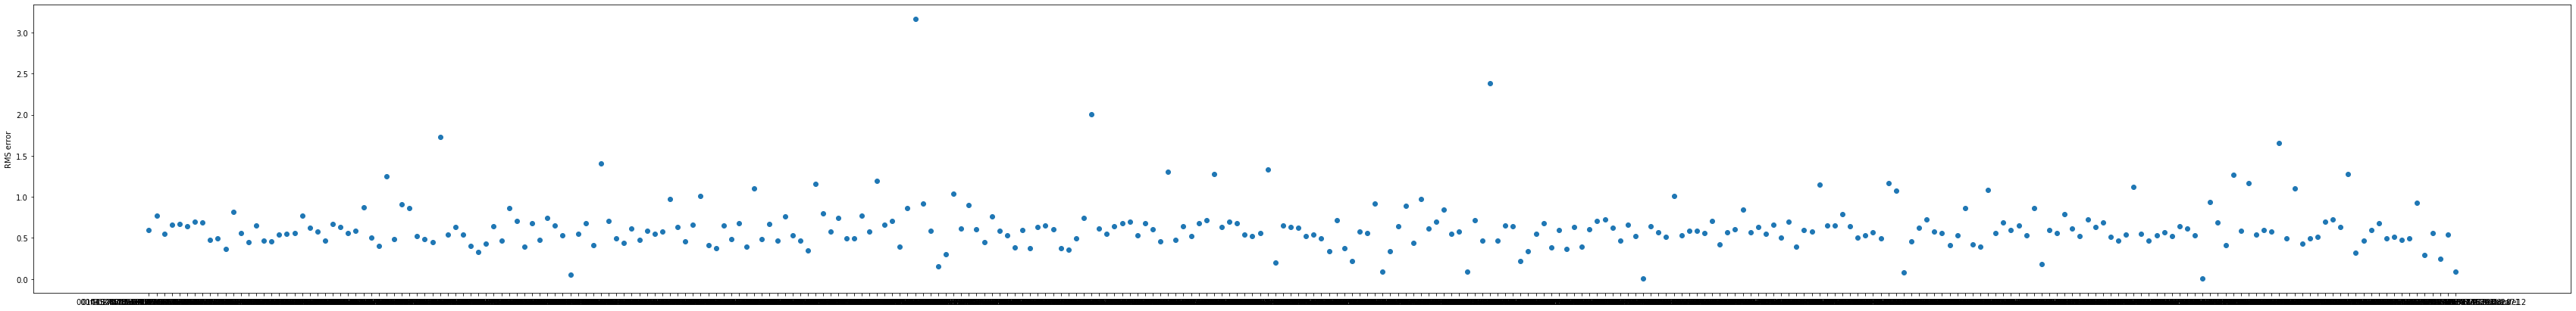

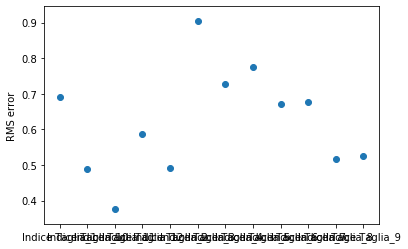

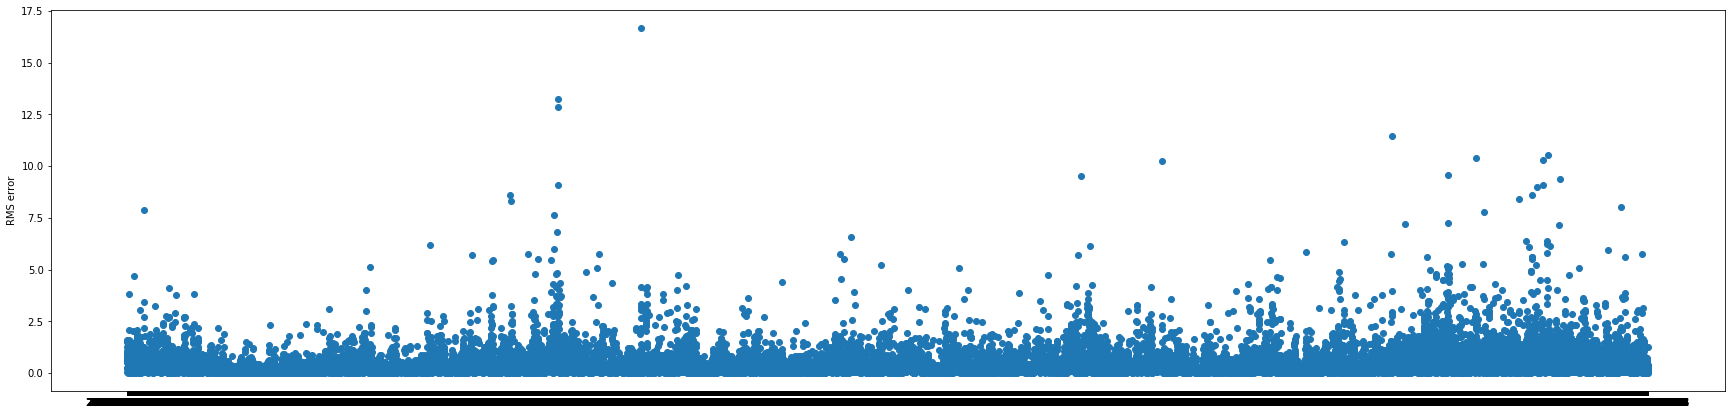

In [14]:
from sklearn.metrics import mean_squared_error
from math import sqrt
import xgboost

# temp contains columns which were dropped before training
prediction = model.predict(xgboost.DMatrix(X_test[temp_test['Negozio'] != 0])) # only predict on the real data points, not the augmented ones
y_test_nonaug = y_test[temp_test['Negozio'] != 0]

X_test_full = np.concatenate((X_test[temp_test['Negozio'] != 0], temp_test[temp_test['Negozio'] != 0]), axis=1)
columnNames_full = np.array(columnNames.values.tolist()+columnsTemp)
for feature in ['Negozio', 'Indice Taglia', 'EAN']:
    # get all columns that start with feature, calculate rmse for the predictions arising from them, plot as scatterplot
    column_names, rmses, figsize = [], [], None
    column_indices = [i for i in range(columnNames_full.shape[0]) if columnNames_full[i].startswith(feature)]
    if (len(column_indices) == 1): # for non-categorical columns
        columnIndex = int(column_indices[0])
        for featureValue in np.unique(X_test_full[:, columnIndex]): # calculate rmse for the all the separate values of the current feature
            row_indices = np.nonzero(X_test_full[:,columnIndex] == featureValue)
            rmse = sqrt(mean_squared_error(y_test_nonaug[row_indices], prediction[row_indices])) # rms error for each separate value in columnNames[column_indices]
            column_names.append(str(featureValue))
            rmses.append(rmse)
            if feature == 'Negozio': figsize = (60,7)
            else:                    figsize = (30,7)
    else: # for categorical (one-hot encoded) columns
        for columnName, columnIndex in np.column_stack(np.unique(columnNames_full[column_indices], return_index=True)): # calculate rmse for the all the separate values of the current feature
            row_indices = np.nonzero(X_test_full[:,int(columnIndex)])
            rmse = sqrt(mean_squared_error(y_test_nonaug[row_indices], prediction[row_indices])) # rms error for each separate value in columnNames[column_indices]
            column_names.append(str(columnName))
            rmses.append(rmse)
    
    plt.scatter(column_names, rmses)
    #plt.xticks(rotation='vertical')
    #plt.xlabel(feature)
    plt.ylabel("RMS error")
    if (figsize is not None): plt.gcf().set_size_inches(*figsize)
    plt.show()
    plt.close()